In [ ]:
!pip install shap lime transformers torch torchvision

In [2]:
# Importing necessary libraries
import torch
from transformers import XLMRobertaForTokenClassification, DistilBertForTokenClassification
from transformers import XLMRobertaTokenizer, DistilBertTokenizer
import shap
from lime.lime_text import LimeTextExplainer
import numpy as np

In [ ]:
# Load models and tokenizers
model_name_xlm = 'xlm-roberta-base'  # XLM-Roberta
model_name_distil = 'distilbert-base-multilingual-cased'  # DistilBERT
tokenizer_xlm = XLMRobertaTokenizer.from_pretrained(model_name_xlm)
tokenizer_distil = DistilBertTokenizer.from_pretrained(model_name_distil)

In [ ]:
# Load models
model_xlm = XLMRobertaForTokenClassification.from_pretrained(model_name_xlm)
model_distil = DistilBertForTokenClassification.from_pretrained(model_name_distil)

In [ ]:
# Set models to evaluation mode
model_xlm.eval()
model_distil.eval()

In [6]:
# Sample tokenized input data
sample_data = [
    "John Smith visited New York City.",
    "The river bank near the bank of America was flooded."
]

In [7]:
# Function to tokenize input for SHAP
def tokenize_for_shap(text):
    return tokenizer_xlm(text, return_tensors="pt", padding=True, truncation=True)

# SHAP Implementation
def explain_with_shap(model, text):
    # Tokenize input
    tokenized_data = tokenize_for_shap(text)

    # Define a function to make predictions
    def predict_fn(input_ids):
        input_ids = torch.tensor(input_ids)  # Ensure input_ids is a tensor
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits
            return torch.softmax(logits, dim=2).cpu().numpy()  # Get probabilities

    # Create SHAP explainer
    explainer = shap.KernelExplainer(predict_fn, tokenized_data['input_ids'].cpu().numpy())

    # Compute SHAP values for the tokenized input
    shap_values = explainer.shap_values(tokenized_data['input_ids'].cpu().numpy())

    # Plot SHAP summary for the first class (change index if necessary)
    feature_names = tokenizer_xlm.convert_ids_to_tokens(tokenized_data['input_ids'][0].tolist())
    shap.summary_plot(shap_values[0], feature_names=feature_names)

In [8]:
# LIME Implementation for token classification
def explain_with_lime(model, text):
    explainer = LimeTextExplainer(class_names=["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-MISC", "I-MISC"])  # Adjust class names as necessary

    # Define a prediction function for LIME
    def predict_fn(texts):
        inputs = tokenizer_distil(texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(inputs['input_ids'].to(model.device))
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=2)  # Shape (batch_size, seq_length, num_classes)

            # Since LIME expects a 2D array (batch_size, num_classes), we will average the probabilities across tokens
            token_probabilities = probabilities.mean(dim=1)  # Averaging across tokens (seq_length axis)
            return token_probabilities.cpu().numpy()

    # Generate LIME explanation
    explanation = explainer.explain_instance(text, predict_fn, num_features=10)

    # Store results for reporting
    lime_analysis = {
        'lime_exp': explanation,
        'text': text
    }

    return lime_analysis


SHAP Explanation for XLM-Roberta:


  0%|          | 0/1 [00:00<?, ?it/s]

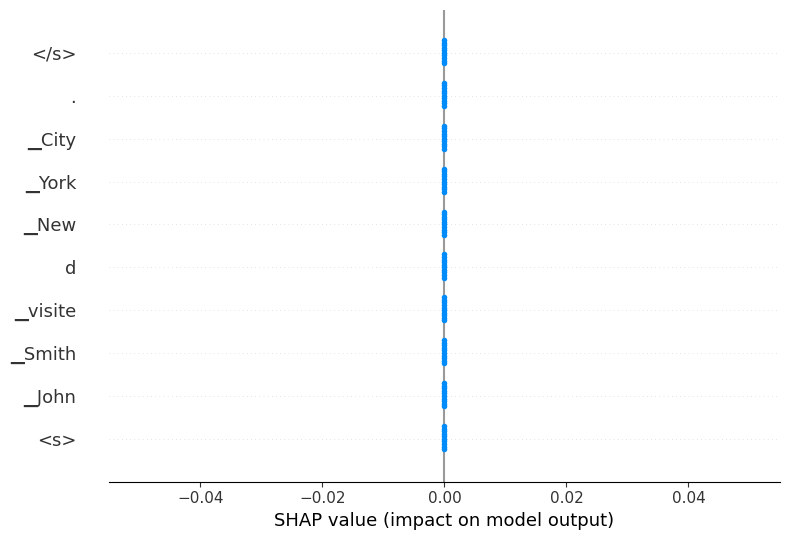

LIME Explanation for DistilBERT:


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


[('The', 0.018575834892134973), ('bank', -0.015047445442898015), ('near', 0.011961731955877311), ('river', -0.007111240631169503), ('flooded', -0.006310095401073284), ('was', -0.005736505108450883), ('America', -0.005696276804064172), ('the', 0.0018395928161189705), ('of', 0.001034888492268577)]


In [9]:
# Explain the models
print("SHAP Explanation for XLM-Roberta:")
explain_with_shap(model_xlm, sample_data[0])
print("LIME Explanation for DistilBERT:")
lime_result = explain_with_lime(model_distil, sample_data[1])
print(lime_result['lime_exp'].as_list())  # Print the LIME explanation result